In [3]:
# https://en.wikipedia.org/wiki/Modern_portfolio_theory
# https://blog.quantopian.com/markowitz-portfolio-optimization-2/
# http://www.pythonforfinance.net/2017/01/21/investment-portfolio-optimisation-with-python/
# http://rexyroo.github.io/Articles/2014/03/09/markowitz_portfolio_optimization/
# http://ahmedas91.github.io/blog/2016/03/01/efficient-frontier-with-python/
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import quandl
quandl.ApiConfig.api_key = 'JgrixskwB3MtGDkJtxms'
%matplotlib inline

In [7]:
start = pd.to_datetime('2012-01-01')
end = pd.to_datetime('2017-08-01')

In [8]:
aapl = quandl.get('WIKI/AAPL.11',start_date=start,end_date=end)
csco = quandl.get('WIKI/CSCO.11',start_date=start,end_date=end)
ibm = quandl.get('WIKI/IBM.11',start_date=start,end_date=end)
amzn = quandl.get('WIKI/AMZN.11',start_date=start,end_date=end)

In [10]:
stocks = pd.concat([aapl, csco, ibm, amzn], axis=1)
stocks.columns = ['AAPL','CSCO','IBM','AMZN']

In [11]:
stocks.head()

,AAPL,CSCO,IBM,AMZN
Date,,,,
2012-01-03,52.848787,15.752778,159.151010,179.03
2012-01-04,53.132802,16.057180,158.501763,177.51
2012-01-05,53.722681,15.997991,157.750003,177.61
2012-01-06,54.284287,15.938801,155.938944,182.61
2012-01-09,54.198183,16.040268,155.127385,178.56


In [13]:
stocks.pct_change(1).mean()

AAPL    0.000868
CSCO    0.000593
IBM    -0.000006
AMZN    0.001399
dtype: float64

In [14]:
# Correlation pearsons-r
stocks.pct_change(1).corr()

,AAPL,CSCO,IBM,AMZN
AAPL,1.000000,0.295565,0.282805,0.245893
CSCO,0.295565,1.000000,0.407741,0.278479
IBM,0.282805,0.407741,1.000000,0.249844
AMZN,0.245893,0.278479,0.249844,1.000000


In [15]:
stocks.pct_change(1).head()

,AAPL,CSCO,IBM,AMZN
Date,,,,
2012-01-03,NaN,NaN,NaN,NaN
2012-01-04,0.005374,0.019324,-0.004079,-0.008490
2012-01-05,0.011102,-0.003686,-0.004743,0.000563
2012-01-06,0.010454,-0.003700,-0.011481,0.028152
2012-01-09,-0.001586,0.006366,-0.005204,-0.022178


In [82]:
log_ret = np.log(stocks/stocks.shift(1))
log_ret.head()

,AAPL,CSCO,IBM,AMZN
Date,,,,
2012-01-03,NaN,NaN,NaN,NaN
2012-01-04,0.005360,0.019139,-0.004088,-0.008526
2012-01-05,0.011041,-0.003693,-0.004754,0.000563
2012-01-06,0.010400,-0.003707,-0.011547,0.027763
2012-01-09,-0.001587,0.006346,-0.005218,-0.022428


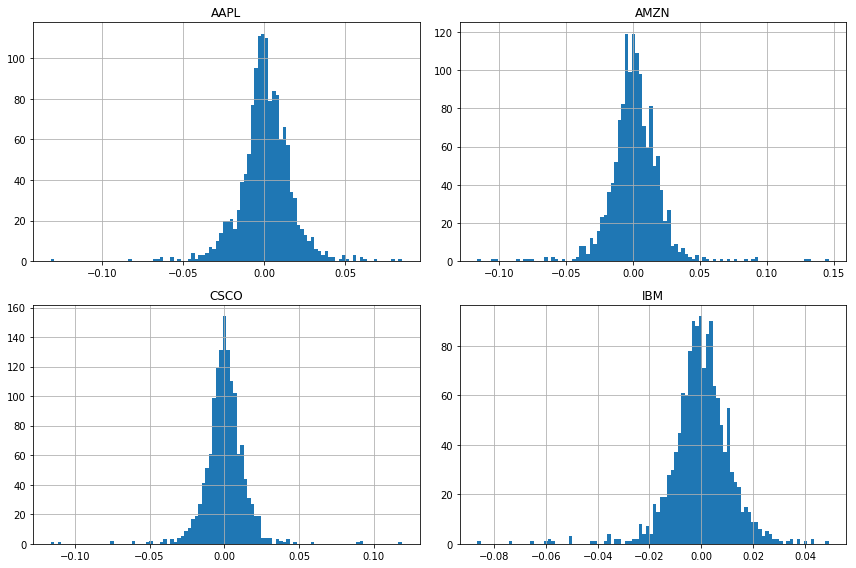

In [19]:
log_ret.hist(bins=100,figsize=(12,8));
plt.tight_layout();

In [20]:
log_ret.mean()

AAPL    0.000741
CSCO    0.000497
IBM    -0.000072
AMZN    0.001223
dtype: float64

In [21]:
log_ret.cov()

,AAPL,CSCO,IBM,AMZN
AAPL,0.000254,0.000065,0.000052,0.000073
CSCO,0.000065,0.000192,0.000065,0.000072
IBM,0.000052,0.000065,0.000134,0.000054
AMZN,0.000073,0.000072,0.000054,0.000348


In [22]:
log_ret.cov() * 252 #252 busines days

,AAPL,CSCO,IBM,AMZN
AAPL,0.064038,0.016412,0.013021,0.018494
CSCO,0.016412,0.048388,0.016410,0.018235
IBM,0.013021,0.016410,0.033668,0.013591
AMZN,0.018494,0.018235,0.013591,0.087605


In [34]:
np.random.seed(101)
print(stocks.columns)
weights = np.array(np.random.random(4))
print("Random Weights: " + str(weights))
weights = weights/np.sum(weights)
print("Rebalanced Weights: " + str(weights))

# Expeceted Return
expected_ret = np.sum((log_ret.mean() * weights) * 252) # 252 Business days in a year
print("Expected Portfolio Return: " + str(expected_ret))

# Expected Volatility 
expected_volatility = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov()*252,weights)))
print("Expected Volatility: " + str(expected_volatility))

# Sharpe Ratio
SR = expected_ret/expected_volatility
print("Sharpe Ratio: " + str(SR))

Index(['AAPL', 'CSCO', 'IBM', 'AMZN'], dtype='object')
Random Weights: [ 0.51639863  0.57066759  0.02847423  0.17152166]
Rebalanced Weights: [ 0.40122278  0.44338777  0.02212343  0.13326603]
Expected Portfolio Return: 0.17115794941
Expected Volatility: 0.178882818495
Sharpe Ratio: 0.956816036609


In [43]:
np.random.seed(101)

num_portfolios = 25000
all_weights = np.zeros((num_portfolios, len(stocks.columns)))
return_array = np.zeros(num_portfolios)
volatility_array = np.zeros(num_portfolios)
sharpe_array = np.zeros(num_portfolios)

for index in range(num_portfolios):
    # Weights 
    weights = np.array(np.random.random(4))
    weights = weights/np.sum(weights)
    all_weights[index,:] = weights
    
    # Expeceted Return
    return_array[index] = np.sum((log_ret.mean() * weights) * 252) # 252 Business days in a year
    # Expected Volatility 
    volatility_array[index] = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov()*252,weights)))
    # Sharpe Ratio
    sharpe_array[index] = return_array[index]/volatility_array[index]


In [44]:
sharpe_array.max()

1.1658206199577343

In [46]:
sharpe_array.argmax()

2434

In [47]:
all_weights[sharpe_array.argmax(),:]

array([ 0.32252283,  0.15277098,  0.00198024,  0.52272595])

In [55]:
max_sr_ret = return_array[sharpe_array.argmax()]
max_sr_vol = volatility_array[sharpe_array.argmax()]

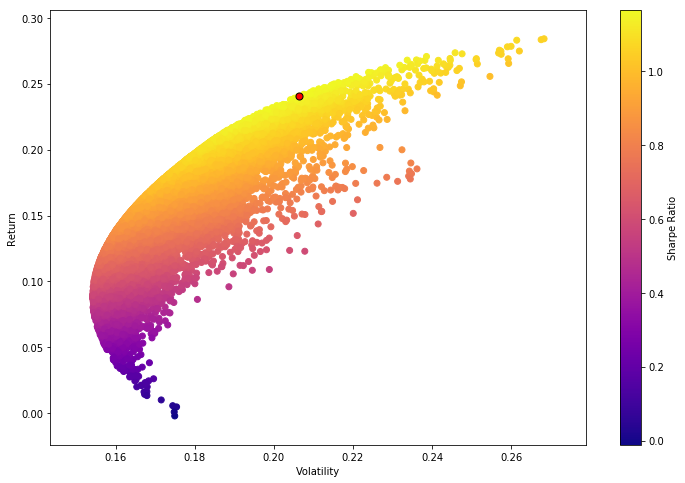

In [57]:
plt.figure(figsize=(12,8))
plt.scatter(volatility_array, return_array, c=sharpe_array, cmap='plasma')
plt.colorbar(label="Sharpe Ratio")
plt.xlabel('Volatility')
plt.ylabel('Return');
plt.scatter(max_sr_vol, max_sr_ret, c='red', s=50, edgecolor='black');

In [76]:
weights

array([ 0.14902883,  0.05446929,  0.47737392,  0.31912796])

In [62]:
def get_ret_vol_sr(weights):
    weights = np.array(weights)
    ret = np.sum((log_ret.mean() * weights) * 252)
    vol = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov()*252,weights)))
    sr = ret/vol
    return np.array([ret,vol,sr])

In [63]:
def neg_sharpe(weights):
    return get_ret_vol_sr(weights)[2] * -1

In [64]:
def check_sum(weights):
    # return 0 if the sum of the wieghts is 1
    return np.sum(weights) -1

In [65]:
cons = ({'type':'eq', 'fun':check_sum})

In [66]:
bounds = ((0,1),(0,1),(0,1),(0,1))

In [83]:
init_guess = [0.25,0.25,0.25,0.25]

In [68]:
# minimize func from scipy
opt_results = minimize(neg_sharpe, init_guess, method='SLSQP', bounds=bounds, constraints=cons)

In [69]:
opt_results

     fun: -1.1667586585168692
     jac: array([  3.42875719e-05,   9.54419374e-05,   4.66563061e-01,
        -4.89503145e-05])
 message: 'Optimization terminated successfully.'
    nfev: 42
     nit: 7
    njev: 7
  status: 0
 success: True
       x: array([ 0.32655634,  0.15084451,  0.        ,  0.52259915])

In [70]:
opt_results.x

array([ 0.32655634,  0.15084451,  0.        ,  0.52259915])

In [71]:
get_ret_vol_sr(opt_results.x)

array([ 0.2409858 ,  0.20654297,  1.16675866])

In [72]:
# Efficient Frontier 
frontier_y = np.linspace(0,0.3,100) # see scatter bullet above: 0.3 is the max

In [73]:
def minimize_volatility(weights):
    return get_ret_vol_sr(weights)[1]

In [78]:
frontier_volatility = []

for possible_return in frontier_y:
    cons = ({'type':'eq', 'fun':check_sum},{'type':'eq', 'fun':lambda w: get_ret_vol_sr(w)[0]-possible_return})
    results = minimize(minimize_volatility,init_guess,method='SLSQP',bounds=bounds, constraints=cons)
    frontier_volatility.append(results['fun'])

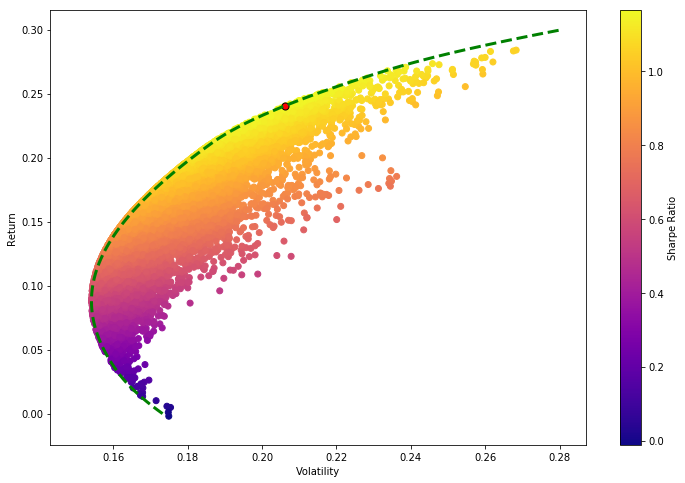

In [80]:
plt.figure(figsize=(12,8))
plt.scatter(volatility_array, return_array, c=sharpe_array, cmap='plasma')
plt.colorbar(label="Sharpe Ratio")
plt.xlabel('Volatility')
plt.ylabel('Return');
plt.scatter(max_sr_vol, max_sr_ret, c='red', s=50, edgecolor='black');
plt.plot(frontier_volatility,frontier_y,"g--",linewidth=3);

In [84]:
foo=[]